In [13]:
!pip install pyspark
!pip install findspark  
!pip install pandas
!pip install -U scikit-learn
!pip install -U matplotlib
!pip install treeplot

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [76]:
from pyspark.sql import SparkSession
import findspark
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import * 
from pyspark.sql.types import StringType,BooleanType,DateType, IntegerType  
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
from pyspark.sql import SQLContext
from sklearn.metrics import confusion_matrix
from pyspark.conf import SparkConf
from sklearn.metrics import roc_curve, roc_auc_score



findspark.init()

spark = SparkSession.builder.appName("Pyspark Tutorial")\
                    .config("spark.memory.offHeap.enabled","true")\
                    .config("spark.memory.offHeap.size","10g")\
                    .getOrCreate()


# check spark configuration

spark

In [45]:
!curl https://raw.githubusercontent.com/Sepay/Programming/main/obesity.csv >> obesity.csv
    
df = spark.read.csv('obesity.csv',header=True,sep=",")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  257k  100  257k    0     0  1539k      0 --:--:-- --:--:-- --:--:-- 1532k


In [46]:
df = df.withColumnRenamed('family_history_with_overweight', 'FH')

In [47]:
df.show(5,0)

+------+---+------+------+---+----+----+---+---------+-----+----+---+---+---+----------+---------------------+-------------------+
|Gender|Age|Height|Weight|FH |FAVC|FCVC|NCP|CAEC     |SMOKE|CH2O|SCC|FAF|TUE|CALC      |MTRANS               |NObeyesdad         |
+------+---+------+------+---+----+----+---+---------+-----+----+---+---+---+----------+---------------------+-------------------+
|Female|21 |1.62  |64    |yes|no  |2   |3  |Sometimes|no   |2   |no |0  |1  |no        |Public_Transportation|Normal_Weight      |
|Female|21 |1.52  |56    |yes|no  |3   |3  |Sometimes|yes  |3   |yes|3  |0  |Sometimes |Public_Transportation|Normal_Weight      |
|Male  |23 |1.8   |77    |yes|no  |2   |3  |Sometimes|no   |2   |no |2  |1  |Frequently|Public_Transportation|Normal_Weight      |
|Male  |27 |1.8   |87    |no |no  |3   |3  |Sometimes|no   |2   |no |2  |0  |Frequently|Walking              |Overweight_Level_I |
|Male  |22 |1.78  |89.8  |no |no  |2   |1  |Sometimes|no   |2   |no |0  |0  |Someti

In [48]:
df.count()

67583

In [49]:
df= df.drop('TUE')

In [50]:
df.show()

+------+---+------+------+---+----+----+---+----------+-----+----+---+---+----------+--------------------+-------------------+
|Gender|Age|Height|Weight| FH|FAVC|FCVC|NCP|      CAEC|SMOKE|CH2O|SCC|FAF|      CALC|              MTRANS|         NObeyesdad|
+------+---+------+------+---+----+----+---+----------+-----+----+---+---+----------+--------------------+-------------------+
|Female| 21|  1.62|    64|yes|  no|   2|  3| Sometimes|   no|   2| no|  0|        no|Public_Transporta...|      Normal_Weight|
|Female| 21|  1.52|    56|yes|  no|   3|  3| Sometimes|  yes|   3|yes|  3| Sometimes|Public_Transporta...|      Normal_Weight|
|  Male| 23|   1.8|    77|yes|  no|   2|  3| Sometimes|   no|   2| no|  2|Frequently|Public_Transporta...|      Normal_Weight|
|  Male| 27|   1.8|    87| no|  no|   3|  3| Sometimes|   no|   2| no|  2|Frequently|             Walking| Overweight_Level_I|
|  Male| 22|  1.78|  89.8| no|  no|   2|  1| Sometimes|   no|   2| no|  0| Sometimes|Public_Transporta...|Overw

# Variáveis

Retirou-se a coluna dos telemoveis 

# TRATAMENTO DE DADOS

Alterou-se as colunas Gender, FH, CAEC, SMOLE, SCC, CALC, MTRANS, OBESITY para inteiros para ser mais facil executar os algoritmos


In [51]:
df.groupBy('NObeyesdad').count().show()

+-------------------+-----+
|         NObeyesdad|count|
+-------------------+-----+
|   Obesity_Type_III|10368|
| Overweight_Level_I| 9280|
|    Obesity_Type_II| 9504|
|Insufficient_Weight| 8704|
|Overweight_Level_II| 9280|
|      Normal_Weight| 9184|
|         NObeyesdad|   31|
|     Obesity_Type_I|11232|
+-------------------+-----+



In [52]:
df = df.withColumn("CAEC", when(col("CAEC")== "Sometimes", 0).when(col("CAEC") == "Frequently", 1).otherwise(2))
df = df.withColumn("Gender", when(col("Gender")== "Female", 0).otherwise(1))
df = df.withColumn("FH", when(col("FH")== "yes", 0).otherwise(1))
df = df.withColumn("FAVC", when(col("FAVC")== "yes", 0).otherwise(1))
df = df.withColumn("SMOKE", when(col("SMOKE")== "yes", 0).otherwise(1))
df = df.withColumn("SCC", when(col("SCC")== "yes", 0).otherwise(1))
df = df.withColumn("CALC", when(col("CALC")== "no", 0).when(col("CALC") == "Sometimes", 1).when(col("CALC")=="Frequently", 2).otherwise(3))
df = df.withColumn("MTRANS", when(col("MTRANS")== "Public_Transportation", 0).when(col("MTRANS") == "Automobile", 0).when(col("MTRANS")=="Motorbike", 0).otherwise(1))
df = df.withColumn("NObeyesdad", when(col("NObeyesdad")== "Insufficient_Weight", 0).when(col("NObeyesdad") == "Normal_Weight", 0).when(col("NObeyesdad")=="Overweight_Level_I", 0).when(col("NObeyesdad")== "Overweight_Level_II",0).otherwise(1))

In [53]:
df = df.withColumnRenamed("family_history_with_overweight","Family_HIST")
df = df.withColumnRenamed('FAVC','CALORICFOOD')
df=df.withColumnRenamed('Gender','GENDER')
df=df.withColumnRenamed('Age','AGE')
df=df.withColumnRenamed('Weight','WEIGHT')
df=df.withColumnRenamed('Height','HEIGHT')
df=df.withColumnRenamed('FCVC','VEGET')
df=df.withColumnRenamed('NCP','MEALS')
df=df.withColumnRenamed('CAEC','BETWEENMEALS')
df=df.withColumnRenamed('CH2O','H20')
df=df.withColumnRenamed('SCC','CALORIES')
df=df.withColumnRenamed('FAF','PHYSY')
df=df.withColumnRenamed('CALC','ALCH')
df=df.withColumnRenamed('MTRANS','TRANSPORT')
df=df.withColumnRenamed('NObeyesdad','OBESITY')

In [54]:
df.show()

+------+---+------+------+---+-----------+-----+-----+------------+-----+---+--------+-----+----+---------+-------+
|GENDER|AGE|HEIGHT|WEIGHT| FH|CALORICFOOD|VEGET|MEALS|BETWEENMEALS|SMOKE|H20|CALORIES|PHYSY|ALCH|TRANSPORT|OBESITY|
+------+---+------+------+---+-----------+-----+-----+------------+-----+---+--------+-----+----+---------+-------+
|     0| 21|  1.62|    64|  0|          1|    2|    3|           0|    1|  2|       1|    0|   0|        0|      0|
|     0| 21|  1.52|    56|  0|          1|    3|    3|           0|    0|  3|       0|    3|   1|        0|      0|
|     1| 23|   1.8|    77|  0|          1|    2|    3|           0|    1|  2|       1|    2|   2|        0|      0|
|     1| 27|   1.8|    87|  1|          1|    3|    3|           0|    1|  2|       1|    2|   2|        1|      0|
|     1| 22|  1.78|  89.8|  1|          1|    2|    1|           0|    1|  2|       1|    0|   1|        0|      0|
|     1| 29|  1.62|    53|  1|          0|    2|    3|           0|    1

Converter tudo para int

In [55]:

df = df.withColumn("VEGET",col("VEGET").cast(IntegerType())) \
    .withColumn("MEALS",col("MEALS").cast(IntegerType())) \
    .withColumn("H20",col("H20").cast(IntegerType())) \
    .withColumn("PHYSY",col("PHYSY").cast(IntegerType()))
df = df.fillna(0)
df.printSchema()

root
 |-- GENDER: integer (nullable = false)
 |-- AGE: string (nullable = true)
 |-- HEIGHT: string (nullable = true)
 |-- WEIGHT: string (nullable = true)
 |-- FH: integer (nullable = false)
 |-- CALORICFOOD: integer (nullable = false)
 |-- VEGET: integer (nullable = true)
 |-- MEALS: integer (nullable = true)
 |-- BETWEENMEALS: integer (nullable = false)
 |-- SMOKE: integer (nullable = false)
 |-- H20: integer (nullable = true)
 |-- CALORIES: integer (nullable = false)
 |-- PHYSY: integer (nullable = true)
 |-- ALCH: integer (nullable = false)
 |-- TRANSPORT: integer (nullable = false)
 |-- OBESITY: integer (nullable = false)



In [56]:

assemble=VectorAssembler(inputCols=[
    'FH','CALORICFOOD', "SMOKE", "VEGET", "MEALS", 
    "BETWEENMEALS", "H20", "CALORIES", "PHYSY", "ALCH"
], outputCol='features')

In [57]:
assembled_data=assemble.transform(df)

In [58]:
scale=StandardScaler(inputCol='features',outputCol='standardized')
scale=scale.fit(assembled_data)
scale_output= scale.transform(assembled_data)

scale_output.select('standardized').show(2,truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------+
|standardized                                                                                                                     |
+---------------------------------------------------------------------------------------------------------------------------------+
|[0.0,3.1173709787072306,7.00141709593654,3.3278244592664774,3.6072235328826476,0.0,3.3355179356296287,4.800724241494605,0.0,0.0] |
|[0.0,3.1173709787072306,0.0,4.991736688899716,3.6072235328826476,0.0,5.003276903444443,0.0,3.6032638500329375,1.9321945372474882]|
+---------------------------------------------------------------------------------------------------------------------------------+
only showing top 2 rows



In [59]:
finalData = scale_output.select("features", "OBESITY")
train, test =finalData.randomSplit([0.8,0.2])

In [60]:

lr = LogisticRegression(featuresCol="features" ,labelCol="OBESITY", maxIter=5)
lrModel = lr.fit(train)

In [61]:
predictions = lrModel.transform(test)
predictions.select("OBESITY", "features", "rawPrediction", "prediction", "probability").toPandas().head(5)

,OBESITY,features,rawPrediction,prediction,probability
0,0,"(1.0, 0.0, 1.0, 3.0, 2.0, 0.0, 2.0, 0.0, 0.0, ...","[4.373470752377623, -4.373470752377623]",0.0,"[0.9875495604078589, 0.012450439592141094]"
1,0,"(1.0, 0.0, 1.0, 3.0, 2.0, 0.0, 2.0, 0.0, 0.0, ...","[4.373470752377623, -4.373470752377623]",0.0,"[0.9875495604078589, 0.012450439592141094]"
2,0,"(1.0, 0.0, 1.0, 3.0, 2.0, 0.0, 2.0, 0.0, 0.0, ...","[4.373470752377623, -4.373470752377623]",0.0,"[0.9875495604078589, 0.012450439592141094]"
3,0,"(1.0, 0.0, 1.0, 3.0, 2.0, 0.0, 2.0, 0.0, 0.0, ...","[4.373470752377623, -4.373470752377623]",0.0,"[0.9875495604078589, 0.012450439592141094]"
4,1,"(0.0, 1.0, 0.0, 2.0, 3.0, 0.0, 3.0, 1.0, 0.0, ...","[0.41921566387083375, -0.41921566387083375]",0.0,"[0.6032955498926751, 0.3967044501073249]"


In [62]:


eval = BinaryClassificationEvaluator(rawPredictionCol = "prediction", labelCol = "OBESITY")
auc = eval.evaluate(predictions)
print(auc)

0.7667610745816369


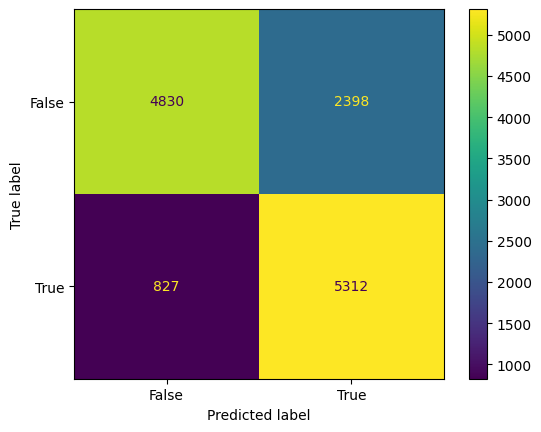

In [71]:
from sklearn import metrics
y_true = predictions.select("OBESITY")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnfMatrix = confusion_matrix(y_true, y_pred)


cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cnfMatrix, display_labels = [False, True])
cm_display.plot()
plt.show() 

In [72]:
FP = predictions.where(predictions["OBESITY"] == predictions["prediction"]).count()
accuracy = FP /float(predictions.count())
accuracy

0.7587341961547094

Text(0, 0.5, 'True Positive Rate')

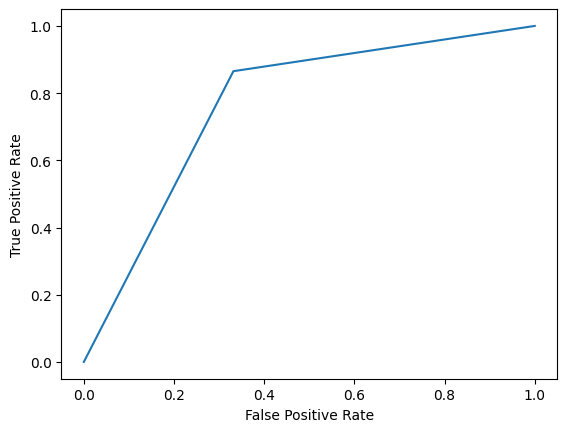

In [75]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, threshold = roc_curve(y_true, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [77]:
paramGrid = ParamGridBuilder()\
            .addGrid(lr.regParam, [0.01,0.5,2.0])\
            .addGrid(lr.elasticNetParam, [0.0,0.5,1.0])\
            .addGrid(lr.maxIter, [1,5,10])\
            .build()


In [78]:
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid,
                    evaluator=eval, numFolds=5 , parallelism=4)

In [79]:
cvModel = cv.fit(train)

In [80]:
predictions_cv = cvModel.transform(test)
eval.evaluate(predictions_cv)

0.771215007644792

In [81]:
FP = predictions_cv.where(predictions_cv["OBESITY"] == predictions_cv["prediction"]).count()
accuracy = FP /float(predictions_cv.count())
accuracy

0.7630732400688263

### Decision trees

In [82]:
!curl https://raw.githubusercontent.com/Sepay/Programming/main/obesity.csv >> obesity.csv
    
df_knn = spark.read.csv('obesity.csv',header=True,sep=",")
df_knn.show()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  257k  100  257k    0     0   390k      0 --:--:-- --:--:-- --:--:--  390k
+------+---+------+------+------------------------------+----+----+---+----------+-----+----+---+---+---+----------+--------------------+-------------------+
|Gender|Age|Height|Weight|family_history_with_overweight|FAVC|FCVC|NCP|      CAEC|SMOKE|CH2O|SCC|FAF|TUE|      CALC|              MTRANS|         NObeyesdad|
+------+---+------+------+------------------------------+----+----+---+----------+-----+----+---+---+---+----------+--------------------+-------------------+
|Female| 21|  1.62|    64|                           yes|  no|   2|  3| Sometimes|   no|   2| no|  0|  1|        no|Public_Transporta...|      Normal_Weight|
|Female| 21|  1.52|    56|                           yes|  no|   3|  3| Sometimes|  yes|   3|yes|  3|  0| Sometimes|Public_Transpor

In [83]:
df_knn = df_knn.drop('TUE')
df_knn = df_knn.withColumn("CAEC", when(col("CAEC")== "Sometimes", 0).when(col("CAEC") == "Frequently", 1).otherwise(2))
df_knn = df_knn.withColumn("Gender", when(col("Gender")== "Female", 0).otherwise(1))
df_knn = df_knn.withColumn("family_history_with_overweight", when(col("family_history_with_overweight")== "yes", 0).otherwise(1))
df_knn = df_knn.withColumn("FAVC", when(col("FAVC")== "yes", 0).otherwise(1))
df_knn = df_knn.withColumn("SMOKE", when(col("SMOKE")== "yes", 0).otherwise(1))
df_knn = df_knn.withColumn("SCC", when(col("SCC")== "yes", 0).otherwise(1))
df_knn = df_knn.withColumn("CALC", when(col("CALC")== "no", 0).when(col("CALC") == "Sometimes", 1).when(col("CALC")=="Frequently", 2).otherwise(3))
df_knn = df_knn.withColumn("MTRANS", when(col("MTRANS")== "Public_Transportation", 0).when(col("MTRANS") == "Automobile", 0).when(col("MTRANS")=="Motorbike", 0).otherwise(1))
df_knn = df_knn.withColumn("NObeyesdad", when(col("NObeyesdad")== "Insufficient_Weight", 1).when(col("NObeyesdad") == "Normal_Weight", 2).when(col("NObeyesdad")=="Overweight_Level_I", 3).when(col("NObeyesdad")== "Overweight_Level_II",4).when(col("NObeyesdad")=="Obesity_Type_I", 5).otherwise(6))

In [84]:
df_knn=df_knn.withColumnRenamed("family_history_with_overweight","FH")
df_knn=df_knn.withColumnRenamed('FAVC','CALORICFOOD')
df_knn=df_knn.withColumnRenamed('Gender','GENDER')
df_knn=df_knn.withColumnRenamed('Age','AGE')
df_knn=df_knn.withColumnRenamed('Weight','WEIGHT')
df_knn=df_knn.withColumnRenamed('Height','HEIGHT')
df_knn=df_knn.withColumnRenamed('FCVC','VEGET')
df_knn=df_knn.withColumnRenamed('NCP','MEALS')
df_knn=df_knn.withColumnRenamed('CAEC','BETWEENMEALS')
df_knn=df_knn.withColumnRenamed('CH2O','H20')
df_knn=df_knn.withColumnRenamed('SCC','CALORIES')
df_knn=df_knn.withColumnRenamed('FAF','PHYSY')
df_knn=df_knn.withColumnRenamed('CALC','ALCH')
df_knn=df_knn.withColumnRenamed('MTRANS','TRANSPORT')
df_knn=df_knn.withColumnRenamed('NObeyesdad','OBESITY')

In [85]:
df_knn = df_knn.withColumn("VEGET",col("VEGET").cast(IntegerType())) \
    .withColumn("MEALS",col("MEALS").cast(IntegerType())) \
    .withColumn("H20",col("H20").cast(IntegerType())) \
    .withColumn("PHYSY",col("PHYSY").cast(IntegerType()))\
    .withColumn("AGE",col("AGE").cast(IntegerType()))\
    .withColumn("WEIGHT",col("WEIGHT").cast(IntegerType()))
df_knn = df_knn.dropna()
df_knn.printSchema()

root
 |-- GENDER: integer (nullable = false)
 |-- AGE: integer (nullable = true)
 |-- HEIGHT: string (nullable = true)
 |-- WEIGHT: integer (nullable = true)
 |-- FH: integer (nullable = false)
 |-- CALORICFOOD: integer (nullable = false)
 |-- VEGET: integer (nullable = true)
 |-- MEALS: integer (nullable = true)
 |-- BETWEENMEALS: integer (nullable = false)
 |-- SMOKE: integer (nullable = false)
 |-- H20: integer (nullable = true)
 |-- CALORIES: integer (nullable = false)
 |-- PHYSY: integer (nullable = true)
 |-- ALCH: integer (nullable = false)
 |-- TRANSPORT: integer (nullable = false)
 |-- OBESITY: integer (nullable = false)



In [86]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [87]:
assembleTree=VectorAssembler(inputCols=[
    'FH','CALORICFOOD', "SMOKE",
    "VEGET", "MEALS", "BETWEENMEALS",
    "H20", "CALORIES", "PHYSY",
    "ALCH", "GENDER", "AGE",
    "WEIGHT"
], outputCol='features')

In [88]:
assembledTree_data=assembleTree.transform(df_knn)

In [105]:
scale=StandardScaler(inputCol='features',outputCol='standardized')
scale=scale.fit(assembledTree_data)
scale_outputTree= scale.transform(assembledTree_data)

scale_outputTree.select('standardized').show(2,truncate=False)

finalDataTree = scale_outputTree.select("features", "OBESITY")
trainT, testT =finalDataTree.randomSplit([0.8,0.2])

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|standardized                                                                                                                                                              |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.0,3.1220960102077653,6.999846873386443,3.3374534991170357,3.6140325590437814,0.0,3.341006643637981,4.79967658472357,0.0,0.0,0.0,3.329520177738846,2.4541084029956175]  |
|[0.0,3.1220960102077653,0.0,5.006180248675554,3.6140325590437814,0.0,5.0115099654569715,0.0,3.6030814472792385,1.9403171893801079,0.0,3.329520177738846,2.147344852621165]|
+--------------------------------------------------------------------------------------------------------------------------------------

In [90]:
deciTree = DecisionTreeClassifier(featuresCol="features", labelCol="OBESITY")
deciTree = deciTree.fit(trainT)

predTree = deciTree.transform(testT)
predTree.show()

+--------------------+-------+--------------------+--------------------+----------+
|            features|OBESITY|       rawPrediction|         probability|prediction|
+--------------------+-------+--------------------+--------------------+----------+
|(13,[0,2,3,4,6,11...|      1|[0.0,4697.0,744.0...|[0.0,0.8632604300...|       1.0|
|(13,[0,2,3,4,6,11...|      1|[0.0,4697.0,744.0...|[0.0,0.8632604300...|       1.0|
|(13,[1,3,4,6,8,11...|      2|[0.0,210.0,220.0,...|[0.0,0.4883720930...|       2.0|
|(13,[1,3,4,6,8,11...|      2|[0.0,210.0,220.0,...|[0.0,0.4883720930...|       2.0|
|(13,[1,3,4,6,8,11...|      2|[0.0,210.0,220.0,...|[0.0,0.4883720930...|       2.0|
|(13,[2,3,4,6,7,11...|      3|[0.0,0.0,1273.0,3...|[0.0,0.0,0.25,0.7...|       3.0|
|(13,[2,3,4,6,7,11...|      3|[0.0,0.0,1273.0,3...|[0.0,0.0,0.25,0.7...|       3.0|
|(13,[2,3,4,6,7,11...|      5|[0.0,0.0,24.0,764...|[0.0,0.0,0.003754...|       5.0|
|(13,[2,3,4,6,7,11...|      5|[0.0,0.0,24.0,764...|[0.0,0.0,0.003754...|    

In [91]:
evaluator=MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="OBESITY")
acc = evaluator.evaluate(predTree) 
print(acc)

0.7792224368978486


In [92]:
y_pred=predTree.select("prediction").collect()
y_orig=predTree.select("OBESITY").collect()

In [93]:

cmTree = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cmTree)


Confusion Matrix:
[[1565  217    0    0    0    0]
 [ 283 1079  311  168    9    0]
 [   0  201  975  541  211    0]
 [   0   25    0 1159  656   55]
 [   0    0   24   95 2027  152]
 [   0    0    0    0   18 4079]]


In [94]:
#Desenhar a matriz

In [95]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics



In [104]:
X = finalDataTree["features"]
y = finalDataTree["OBESITY"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

TypeError: object of type 'Column' has no len()